# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


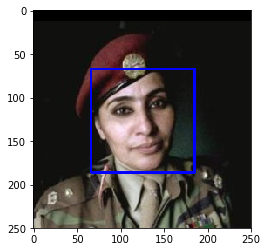

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
At average the front face haar cascade does not detect 2 of the 100 test faces, mostly because people are looking sidewards, so the second ear can not be detected and in general the shading at which haar cascades look at such as the vertical highlight along the nose will most likely fail here.

On the other hand 11 of 100 dogs fullfil the front face haar cascades requirement, because they have at least relative similar shadings along the nose, below the eyes and at the ears.

Detection rate of human faces in human face images using front face haar hascade: 100.00% (100/100)
0 fails
Detection rate of human faces in dog images using front face haar hascade: 11.00% (11/100)
11 fails


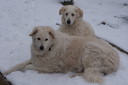

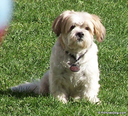

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

from PIL import Image

class cv_detector:
    """Base class for boolean image classification of a given image file and using a customizable detector"""
    
    def __init__(self):
        """Constructor"""
        pass
    
    def detect(self, file_name):
        """Detection function
        
        file_name: The name of the file for which it shall be tested if it fullfills all requirements of this
        detector
        result: True if given image fullfills the requirements"""
        return False
    
class face_haar_cascade_detector(cv_detector):
    """Class which detects if a given image shows a front face of a human or not"""

    def detect(self, file_name):
        # load color (BGR) image
        img = cv2.imread(file_name)
        # convert BGR image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # find faces in image
        result = face_cascade.detectMultiScale(gray)
        return img, True if len(result)>0 else False
    
def verify_haar_cascade(detector, assumed_result, file_name_list, max_log_count, max_size):
    """Verifies a haar cascasde using a list of image file names
    
    detector: The object detector to be used
    assumed_result: The result assumed (True = We assume the cascade detects at least one object)
    file_name_list: The list of file names
    max_log_count: The count of failed images to log
    max_size: The maximum thumbnail size of a failed image to be logged
    return: (Count of successful images with at least one detection, List of images where result mismatched assumed)"""
    
    detection_count = 0
    fail_images = []
    for cur_file_name in file_name_list: # for all images, load image
        image, result = detector.detect(cur_file_name)
        
        detected = False
        
        if result==True: # successfuly detected? count and remember
            detected = True
            detection_count += 1
        
        if detected!=assumed_result: # not the assumed result? remember some fails to be able to log them later
            if len(fail_images)<max_log_count:
                image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                
                max_img_dim = max(image.size)
                if max_img_dim>max_size:
                    scaling = float(max_size)/max_img_dim
                    image = image.resize((int(scaling*image.size[0]), int(scaling*image.size[1])), Image.ANTIALIAS)
                    
                fail_images.append(image)
                
    return detection_count, fail_images
                
def print_results(img_type_name, detected, count, fail_images, fail_count):
    """Logs the results of a verify_haar_cascade execution
    
    img_type_name: A text which described the logged comparison test
    detected: Count of detected objects
    count: Total image count
    fail_images: List of images where the detection failed
    fail_count: Total count of fails"""
    print("Detection rate of {:}: {:0.2f}% ({}/{})".format(img_type_name, float(detected)/count*100, detected, count))
    print("{} fails".format(fail_count))

    for epic_fail in fail_images:
        display(epic_fail)
        

face_detector = face_haar_cascade_detector()

max_log_human_fails = 2 # maximum count of images of failed human detections to be logged
max_log_dog_fails = 2 # maximum count of images incorrectly detected as human face
max_log_img_size = 128 # Maximum size of a failed image's thumbnail in the log
        
humans_detected, human_fails = verify_haar_cascade(face_detector, True, human_files_short, 
                                                   max_log_human_fails, max_log_img_size)
dogs_detected, dog_fails = verify_haar_cascade(face_detector, False, dog_files_short, 
                                               max_log_dog_fails, max_log_img_size)

print_results("human faces in human face images using front face haar hascade", humans_detected, 
              len(human_files_short), human_fails, len(human_files_short)-humans_detected)
print_results("human faces in dog images using front face haar hascade", dogs_detected, 
              len(dog_files_short), dog_fails, dogs_detected)

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__
I think today it still is, because people are used to it from many applications such as an eye based smartphone unlock to look straight into the camera. There are solutions though such as detecting eyes, ears and nose using other cascasdes or deep learning which can be far more tolerant than Viola Jones.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ Dogs were with a 100% rate detected as dog. A human sometimes (about 1%) got accidentally detected as a dog.


In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

class dog_detector_class(cv_detector):
    
    
    def detect(self, file_name):
        img = cv2.imread(file_name)
        result = dog_detector(file_name)
        
        return img, result
    
dog_detect = dog_detector_class()

humans_detected, human_fails = verify_haar_cascade(dog_detect, False, human_files_short, 
                                                   max_log_human_fails, max_log_img_size)
dogs_detected, dog_fails = verify_haar_cascade(dog_detect, True, dog_files_short, 
                                               max_log_dog_fails, max_log_img_size)

print_results("dogs in human face images using ResNet 50 labels for dogs", humans_detected, 
              len(human_files_short), human_fails, humans_detected)
print_results("dogs in dog images using ResNet 50 labels for dogs", dogs_detected, 
              len(dog_files_short), dog_fails, len(dog_files_short)-dogs_detected)

Detection rate of dogs in human face images using ResNet 50 labels for dogs: 0.00% (0/100)
0 fails
Detection rate of dogs in dog images using ResNet 50 labels for dogs: 100.00% (100/100)
0 fails


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 103.46it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I invested a lot of time (nearly a week) for this step of the project, on the one hand to optimize the training process of the model above, but majorly to get an understanding and feeling about which modification has which positive or negative impact on the final result:

* The possible solution above with a 2x2 kernel led to 2.6% accuracy
* The possible solution above with a 3x3 kernel to 3.1%. In other tests I also experienced that 3x3 works fine in general as it's able to represent combination for layer 0 features such as line directions in different rotations very well as well as combining these to layer 1 and layer 2 features such as partial or whole circles.
* Then I added a second fully connected layer which increased the chance to 3.2%... so not really much. Afterwards I tried a fourth convolution layer instead which increased the chance to 3.5% --> also just a small step, but better :)
* After watching the video from Matthew Zeiler showing insights of a CNNs behavior I wasn't really surprised by this, so I added a 5th convolution layer, now 3x3 for 16, 32, 64, 128 and 256 features, a 2x2 pooling after each and finished by a GAP which let to slowly satisfying: 7%
* I experimented with two dozen similar configurations after that over a couple of days, with or without more fully connected layers, with Flatten instead of GAP etc. and reached about 10% at the end.
* I then read at deeplearning.ai from Andrew Ng about batchwise normalization of the input data of each next layer which shall heavily increase the learning speed of CNNs and as positive side effect also slightly increases the regualization and covariance shift.
* It's implementation changed the result tremedous from the previous 10% to now nearly 30% by just adding the normalization layers.
* I tried to further improve the model/network but without success, depending on the weight initialization luck it was sometimes 29%, sometimes 31% but never really much more or less
* I then (as proposed) also implemented image augmentation which still added another 8% to the accuracy with a final result of 43% accuracy with this "from scratch", 5+1 layer final solution.

It was really a great experience :).

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

augment = True

model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 54, 54, 32)        128       
__________

### Compile the Model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [16]:
from keras.preprocessing.image import ImageDataGenerator

if augment==True:
    # create and configure augmented image generator
    datagen_train = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

    # fit augmented image generator on data
    datagen_train.fit(train_tensors)

    # create and configure augmented image generator
    datagen_valid = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

    # fit augmented image generator on data
    datagen_valid.fit(valid_tensors)

In [17]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 20
batch_size = 20


### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

if augment==True:
    print("Fitting model using image augmentation...")
    model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                        steps_per_epoch=train_tensors.shape[0] // batch_size,
                        epochs=epochs, verbose=2, callbacks=[checkpointer],
                        validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                        validation_steps=valid_tensors.shape[0] // batch_size)
else:
    model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
              epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Fitting model using image augmentation...
Epoch 1/20
Epoch 00001: val_loss improved from inf to 4.87483, saving model to saved_models/weights.best.from_scratch.hdf5
 - 58s - loss: 4.5469 - acc: 0.0446 - val_loss: 4.8748 - val_acc: 0.0183
Epoch 2/20
Epoch 00002: val_loss improved from 4.87483 to 4.31747, saving model to saved_models/weights.best.from_scratch.hdf5
 - 57s - loss: 4.1424 - acc: 0.0931 - val_loss: 4.3175 - val_acc: 0.0695
Epoch 3/20
Epoch 00003: val_loss improved from 4.31747 to 3.88647, saving model to saved_models/weights.best.from_scratch.hdf5
 - 57s - loss: 3.8587 - acc: 0.1383 - val_loss: 3.8865 - val_acc: 0.1134
Epoch 4/20
Epoch 00004: val_loss improved from 3.88647 to 3.68076, saving model to saved_models/weights.best.from_scratch.hdf5
 - 57s - loss: 3.5634 - acc: 0.1769 - val_loss: 3.6808 - val_acc: 0.1500
Epoch 5/20
Epoch 00005: val_loss did not improve
 - 57s - loss: 3.3581 - acc: 0.2109 - val_loss: 3.7680 - val_acc: 0.1439
Epoch 6/20
Epoch 00006: val_loss improve

### Load the Model with the Best Validation Loss

In [18]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 47.8469%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [20]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [22]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 310us/step - loss: 12.2723 - acc: 0.1240 - val_loss: 10.5675 - val_acc: 0.2263
Epoch 2/20
6680/6680 [==============================] - 2s 258us/step - loss: 9.8236 - acc: 0.2892 - val_loss: 9.4420 - val_acc: 0.3126
Epoch 3/20
6680/6680 [==============================] - 2s 274us/step - loss: 8.9281 - acc: 0.3680 - val_loss: 9.1562 - val_acc: 0.3413
Epoch 4/20
6680/6680 [==============================] - 2s 259us/step - loss: 8.6427 - acc: 0.4139 - val_loss: 9.0383 - val_acc: 0.3701
Epoch 5/20
6680/6680 [==============================] - 2s 237us/step - loss: 8.5187 - acc: 0.4398 - val_loss: 8.9917 - val_acc: 0.3808
Epoch 6/20
6680/6680 [==============================] - 2s 237us/step - loss: 8.4430 - acc: 0.4512 - val_loss: 8.9859 - val_acc: 0.3796
Epoch 7/20
6680/6680 [==============================] - 2s 262us/step - loss: 8.4057 - acc: 0.4593 - val_loss: 8.9269 - val_acc: 0.3808

### Load the Model with the Best Validation Loss

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [25]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.5407%


### Predict Dog Breed with the Model

In [26]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [31]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

# definition of model indices
model_type_VGG16 = 0
model_type_VGG19 = 1
model_type_ResNet50 = 2
model_type_Inception = 3
model_type_XCeption = 4

# model (file)names
model_names = ["VGG16", "VGG19", "Resnet50", "InceptionV3", "Xception"]

# we are using Resnet 50
selected_model_index = model_type_ResNet50
selected_model_name = model_names[selected_model_index]

print("Selected model: {}".format(selected_model_name))

# load features from disk for the selected model type
bottleneck_features_custom = np.load('bottleneck_features/Dog{}Data.npz'.format(selected_model_name))
train_custom = bottleneck_features_custom['train']
valid_custom = bottleneck_features_custom['valid']
test_custom = bottleneck_features_custom['test']

Selected model: Resnet50


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I visited a couple of benchmark pages such as https://github.com/jcjohnson/cnn-benchmarks which led to furter details about the structure of each of the networks provided here. I decided to use ResNet 50 because it promised the best end accuracy and the performance did not differ a lot.

The model itself was more or less straight forward then as we only still had to use the tremedous amonunt of features which Resnet50 already "highlights" for us and to dense them down to our 133 dog categories, optimized as before via cat crossentropy. Rmsprop worked well for this as for the previous examples.


In [32]:
custom_model = Sequential()
custom_model.add(GlobalAveragePooling2D(input_shape=train_custom.shape[1:]))
custom_model.add(Dense(133, activation='softmax'))

custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [33]:
custom_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [34]:
checkpointer_custom = ModelCheckpoint(filepath='saved_models/weights.best.custom.hdf5', 
                               verbose=1, save_best_only=True)

custom_model.fit(train_custom, train_targets, 
          validation_data=(valid_custom, valid_targets),
          epochs=5, batch_size=20, callbacks=[checkpointer_custom], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 2s 295us/step - loss: 1.6586 - acc: 0.5907 - val_loss: 0.7522 - val_acc: 0.7557
Epoch 2/5
6680/6680 [==============================] - 2s 237us/step - loss: 0.4434 - acc: 0.8621 - val_loss: 0.7199 - val_acc: 0.7868
Epoch 3/5
6680/6680 [==============================] - 1s 216us/step - loss: 0.2667 - acc: 0.9159 - val_loss: 0.7341 - val_acc: 0.7784
Epoch 4/5
6680/6680 [==============================] - 1s 218us/step - loss: 0.1779 - acc: 0.9461 - val_loss: 0.6533 - val_acc: 0.8168
Epoch 5/5
6680/6680 [==============================] - 1s 216us/step - loss: 0.1241 - acc: 0.9603 - val_loss: 0.6666 - val_acc: 0.8132


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [35]:
custom_model.load_weights('saved_models/weights.best.custom.hdf5')


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [36]:
# get index of predicted dog breed for each image in test set
custom_predictions = [np.argmax(custom_model.predict(np.expand_dims(feature, axis=0))) for feature in test_custom]

# report test accuracy
test_accuracy = 100*np.sum(np.array(custom_predictions)==np.argmax(test_targets, axis=1))/len(custom_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.4593%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [37]:
def detect_breed(path):
    # load features
    bottleneck_features = \
        extract_VGG16(path_to_tensor(path)) if selected_model_index==model_type_VGG16 else \
        extract_VGG19(path_to_tensor(path)) if selected_model_index==model_type_VGG19 else \
        extract_Resnet50(path_to_tensor(path)) if selected_model_index==model_type_ResNet50 else \
        extract_InceptionV3(path_to_tensor(path)) if selected_model_index==model_type_Inception else \
        extract_Xception(path_to_tensor(path)) if selected_model_index==model_type_XCeption else None
        
    # predict breed    
    prediction = custom_model.predict(bottleneck_features)
    # return predicted breed
    return dog_names[np.argmax(prediction)], np.max(prediction)

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

94658560/94653016 [==============================] - 2s 0us/step


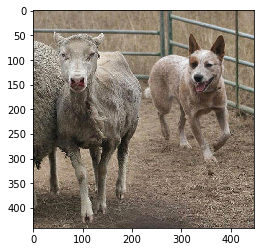

It's a ages/train/043.Canaan_dog (I'm 58.00% sure about that)


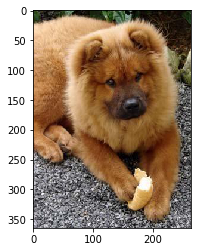

It's a ages/train/051.Chow_chow (I'm 96.71% sure about that)


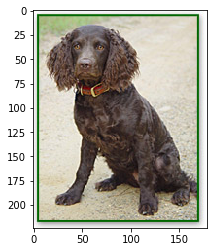

It's a ages/train/009.American_water_spaniel (I'm 70.87% sure about that)


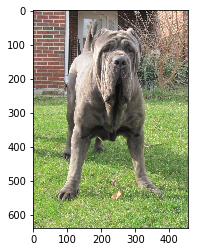

It's a ages/train/105.Neapolitan_mastiff (I'm 98.21% sure about that)


In [38]:
def detect_breed_with_image(img_path):
    breed, likeliness = detect_breed(img_path) 
    
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()    
    
    if dog_detector(img_path):
        print("It's a {} (I'm {:0.2f}% sure about that)".format(breed, likeliness*100))
    elif face_detector.detect(img_path):
        print("It's a human which looks like a {}".format(breed))
    else:
        print("Epic fail :(")

detect_breed_with_image(random.choice(train_files))
detect_breed_with_image(random.choice(train_files))
detect_breed_with_image(random.choice(train_files))
detect_breed_with_image(random.choice(train_files))

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ I'm very positively impressed about how precise the algorithm detects the breed even in more complex pictures like the one with the waves below. Also it's interesting that (likely) due to the pooling I am completely ignored in the picture below and how the dog features, the algorithm is searching for, dominate and results in a certainty of 99.98% even if a human and a dog are in the same picture.

Potential ways of further improvement:

* The input data of the training could have been augmented before which had slightly increased the accuracy.
* The algoritm fails for cross breeds as shown below. We could guess which breeds were involved. It's great that in this case the algorithm was just 56% sure and detected it's own failure.
* There are many very similar looking breeds out there which just differ in size. Every human would instantly know that it can't be a pure Giant Schnauzer, the same it's in case of a Welsh and an Airedale Terrier. If another network such as Cifar would search for objects nearby it could guess the size of the object.
* The algorithm sometimes fails for beards. Because of that I wrote a pure dog vs human qualifier in the optional part above which searchs for the important differences between dogs and humans instead of just looking for dogs or humans.

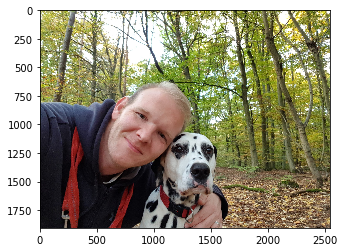

It's a ages/train/057.Dalmatian (I'm 96.84% sure about that)


In [40]:
detect_breed_with_image("custom/PunktMichael.jpg")

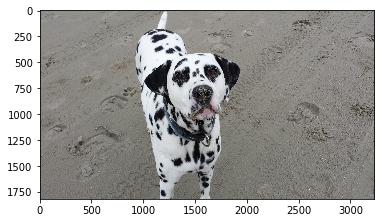

It's a ages/train/057.Dalmatian (I'm 99.99% sure about that)


In [41]:
detect_breed_with_image("custom/Punkt.jpg")

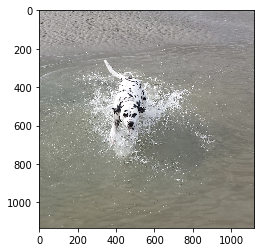

It's a ages/train/057.Dalmatian (I'm 98.81% sure about that)


In [42]:
detect_breed_with_image("custom/PunktWaves.png")

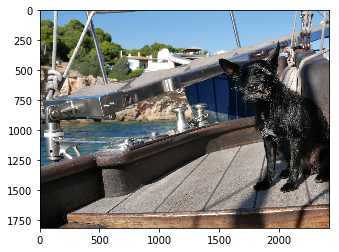

It's a ages/train/021.Belgian_sheepdog (I'm 88.12% sure about that)


In [43]:
detect_breed_with_image("custom/ShipDog.JPG")

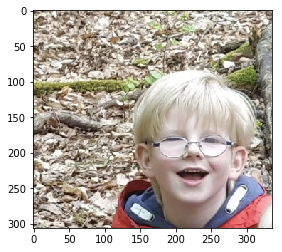

It's a human which looks like a ages/train/127.Silky_terrier


In [44]:
detect_breed_with_image("custom/Maximilian.png")

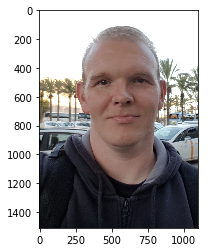

It's a human which looks like a ages/train/127.Silky_terrier


In [45]:
detect_breed_with_image("custom/MiMallorca.png")

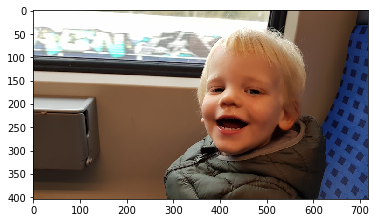

It's a human which looks like a ages/train/127.Silky_terrier


In [46]:
detect_breed_with_image("custom/Johannes_DLND.jpg")